In [164]:
%matplotlib inline
import warnings
import dill
# dill.load_session('msm_whole_trajectories.db')
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md
import matplotlib



In [59]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt


## Load and inspect the data

In [60]:
traj = md.load('data/traj_3.xtc',top= 'data/water_top.pdb')
dt = traj.timestep
traj = md.compute_center_of_mass(traj)
traj.shape

(10000001, 3)

In [61]:
# df = pd.DataFrame(com, columns=['1', '2', '3'])
# df['t'] = traj.time/1000

# df_melt = pd.melt(frame=df, id_vars=['t'], value_vars=['1', '2', '3'], var_name='coord', )

# df_melt.head()

In [62]:
# g = sns.FacetGrid(df_melt.iloc[::100,:], col='coord')
# g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
# g.set_axis_labels('time (ns)', 'position (nm)')

Text(0.5, 0, 'z')

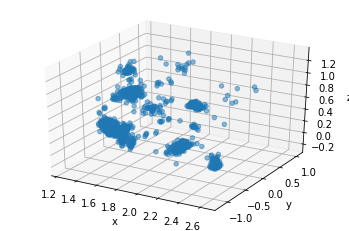

In [63]:
stride=5000
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(xs=traj[::stride,0], ys=traj[::stride,1], zs=traj[::stride,2], alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_zlabel('z')

## Split data into 1ns pieces

This is because we have a wide variety of behaviour across the trajectory and we only want to focus on small chunks at a time. 

In [64]:
window = 1000 # window size in ps
n_frames = int(window/dt) # number of frames in a window
n_splits = traj.shape[0]//n_frames # number of windows in trajectory
traj_split = np.array_split(traj, n_splits) # the split up 

## Set MSM parameters


In [65]:
msm_lag = int(10/dt)
tica_lag = int(5/dt)
n_clusters = int(np.sqrt(n_frames))

## Fit models

In [66]:
# # Fit tica and get tica trajs
# tica_objs = [coor.tica(traj, lag=tica_lag, dim=3,  kinetic_map=True) for traj in traj_split]
# tica_trajs = [x.get_output() for x in tica_objs]

# Cluster using kmeans
dtraj_objs = [coor.cluster_kmeans(traj, k=n_clusters, max_iter=100) for traj in traj_split[:10]]


In [67]:
# Extract dtrajs
dtrajs = [x.dtrajs for x in dtraj_objs]

# get implied timescale plots
msms = [msm.estimate_markov_model(dtraj, lag=msm_lag) for dtraj in dtrajs]

Find the largest gap in the timescales first - some of these might give sink states though. 

In [269]:
ts_ratios = []
for mm in msms:
    ts = mm.timescales()[:5]
    ts_ratio = ts[:-1]/ts[1:]
    max_ratio = np.max(ts_ratio)
    n_states = np.argmax(ts_ratio)+2
    ts_ratios.append((mm, n_states, max_ratio))

Now fit the Hidden Markov Models. 

In [270]:
hmms = [(i, mm.coarse_grain(n)) for i, (mm, n, ratio) in enumerate(ts_ratios) if ratio > 1.5]


In [271]:
# If one of the lifetimes is infinity, that means there's an absorbing state so there's no oscilation
non_absorbing = [i for (i, hmm) in hmms if not np.any(np.abs(hmm.lifetimes)==np.inf)]

In [272]:
hmm_dict = dict(hmms)

In [273]:
hmm_dict

{0: MaximumLikelihoodHMSM(accuracy=0.001, connectivity=None, dt_traj='1 step',
            lag=99, maxit=1000, mincount_connectivity=0.5,
            msm_init=MaximumLikelihoodMSM(connectivity='largest', count_mode='sliding',
            dt_traj='1 step', lag=99, maxerr=1e-08, maxiter=1000000,
            mincount_connectivity='1/n', reversible=True, score_k=10,
            score_method='VAMP2', sparse=False, statdist_constraint=None),
            nstates=2, observe_nonempty=True, reversible=True,
            separate=None, stationary=False, stride=1),
 2: MaximumLikelihoodHMSM(accuracy=0.001, connectivity=None, dt_traj='1 step',
            lag=99, maxit=1000, mincount_connectivity=0.3333333333333333,
            msm_init=MaximumLikelihoodMSM(connectivity='largest', count_mode='sliding',
            dt_traj='1 step', lag=99, maxerr=1e-08, maxiter=1000000,
            mincount_connectivity='1/n', reversible=True, score_k=10,
            score_method='VAMP2', sparse=False, statdist_cons

## Plot results

3 [[ 1.         0.       ]
 [-0.5        0.8660254]
 [-0.5       -0.8660254]]


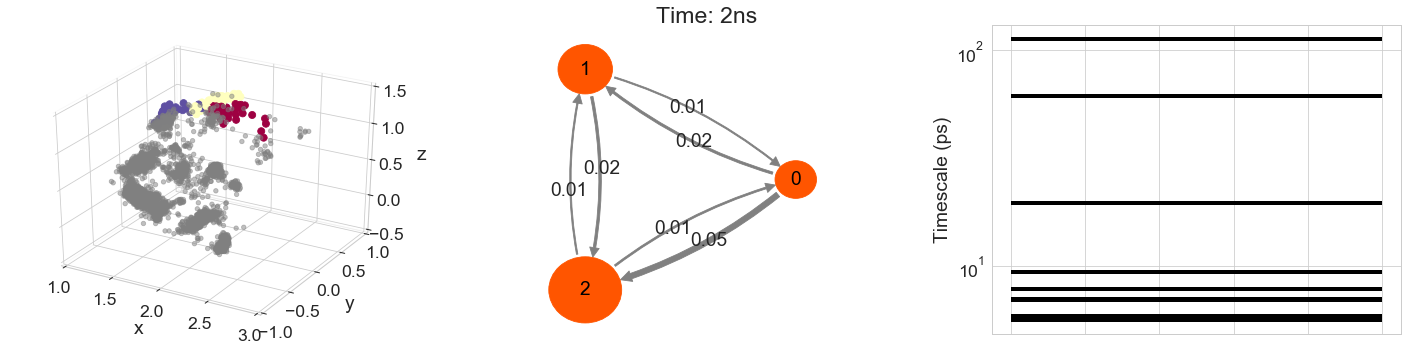

In [294]:
with sns.plotting_context('paper', font_scale=2):
    def axis_labs(ax):
        ax.set_xlim(1,3.); ax.set_ylim(-1, 1.); ax.set_zlim(-0.5, 1.5)
        ax.set_xlabel('x', labelpad=10); ax.set_ylabel('y', labelpad=10); ax.set_zlabel('z', labelpad=10)
        ax.xaxis.pane.fill=False; ax.yaxis.pane.fill=False; ax.zaxis.pane.fill=False
        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
        ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
        ax.zaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
        return ax
    
    # Get the relevant data
    hmm = hmm_dict[idx]
    N = hmm.nstates
    h_states = hmm.
    
    sns.set_style('whitegrid')
    idx = 2
    stride = 10
    big_stride = int(traj.shape[0]/10000)
    
    n_points = traj_split[idx][::stride,0].shape[0]
    
    # Set up figure and color options
    
    fig = plt.figure(figsize=(20, 5))
    fig.suptitle('Time: {}ns'.format(idx), horizontalalignment='center')
    
    cmap_use = 'Spectral'
    cmap = matplotlib.cm.get_cmap(cmap_use,N)
    rgb_1 = cmap(0)
    rgb_2 = cmap(2)
    

    
    # cluster centers
    ax = fig.add_subplot(1,3,1,projection='3d')
    ax.scatter(xs=ccs[:,0], ys=ccs[:,1], zs=ccs[:,2], alpha=1, c=assignments, 
               zorder=1, s=50, cmap=cmap) 
    ax = axis_labs(ax)
    
    # Whole trajectory
    ax.scatter(xs=traj[::big_stride,0], ys=traj[::big_stride,1],
               zs=traj[::big_stride,2], alpha=0.5,s=20, zorder=1, color='grey')
    ax = axis_labs(ax)

    # Network
    ax = fig.add_subplot(1,3,2)
    r = 1
    x = np.array([r * np.cos(2*np.pi*n/N) for n in range(N)])
    y = np.array([r * np.sin(2*np.pi*n/N) for n in range(N)])
    pos = np.vstack((x,y)).T
    
    fig, pos = mplt.plot_markov_model(hmm, ax=ax, arrow_curvature=1.5, 
                                arrow_label_format = '%2.2f', pos=pos,
                                figpadding=0.2, arrow_scale=0.5)
    
    
    ax = fig.add_subplot(1,3,3)
    mm = msms[idx]
    ts = mm.timescales()[:10]*dt
    ax.hlines(ts, 0, 1, lw=4)
    ax.set_ylabel('Timescale (ps)')
    ax.set_yscale('log')
    ax.tick_params(labelbottom = False)
    plt.tight_layout()

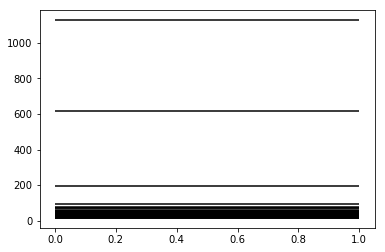

In [151]:
mm = msms[idx]
ts = mm.timescales()
plt.hlines(ts, 0, 1)

In [82]:
hmm = mm.coarse_grain(2)
~np.any(np.abs(hmm.lifetimes)==np.inf)

False

In [3]:
# import dill
# dill.dump_session('msm_whole_trajectories.db')

In [4]:
hmm

MaximumLikelihoodHMSM(accuracy=0.001, connectivity=None, dt_traj='1 step',
           lag=99, maxit=1000, mincount_connectivity=0.5,
           msm_init=MaximumLikelihoodMSM(connectivity='largest', count_mode='sliding',
           dt_traj='1 step', lag=99, maxerr=1e-08, maxiter=1000000,
           mincount_connectivity='1/n', reversible=True, score_k=10,
           score_method='VAMP2', sparse=False, statdist_constraint=None),
           nstates=2, observe_nonempty=True, reversible=True,
           separate=None, stationary=False, stride=1)